In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 489.6 MB 21 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
import numpy as np
import os
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sample_batchsize = 128

In [ ]:
sample_gen = ImageDataGenerator(rescale=1/255)
samaple_dataset = sample_gen.flow_from_directory('/content/drive/MyDrive/Seventh Semester Project/Datasets/Train', batch_size=sample_batchsize)

Found 10081 images belonging to 10 classes.


In [ ]:
class_list = list(samaple_dataset.class_indices.keys())

In [ ]:
print(len(class_list))

10


In [ ]:
images, labels = next(iter(samaple_dataset))

In [ ]:
print(images.shape, labels.shape)

(128, 256, 256, 3) (128, 10)


In [ ]:
def show_images(num_of_images):
  if num_of_images < sample_batchsize:
    fig, ax = plt.subplots(1, num_of_images, figsize=(20, 20))
    for i in range(num_of_images):
      label = class_list[np.argmax(labels[i], axis = 0)]
      ax[i].imshow(images[i])
      ax[i].set_title(label)
      ax[i].set_xticks([])
      ax[i].set_yticks([])
  else:
    print('Enter the number less than batch size otherwise change the batch size as required')

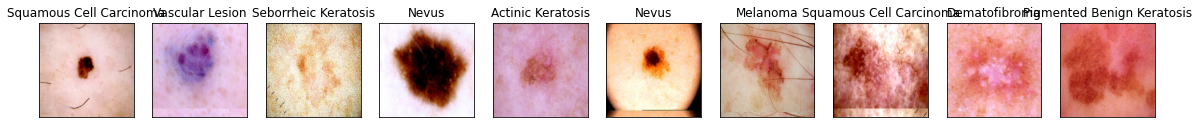

In [ ]:
show_images(10)

In [ ]:
train_path ='/content/drive/MyDrive/Seventh Semester Project/Datasets/Train'
valid_path = '/content/drive/MyDrive/Seventh Semester Project/Datasets/Validate'

Img_size = [224, 224]
batch_size = 512

In [ ]:
## Data Augmentation

train_generator =ImageDataGenerator(rescale = 1/255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=30,
                                   fill_mode='nearest')
valid_generator = ImageDataGenerator(rescale= 1/255)


In [ ]:
# Dataset 

train_datset = train_generator.flow_from_directory(directory=train_path,
                                                   target_size= Img_size,
                                                   class_mode = 'sparse',
                                                   batch_size = batch_size,
                                                   color_mode = 'rgb', )

valid_datset = train_generator.flow_from_directory(directory=valid_path,
                                                   target_size= Img_size,
                                                   class_mode = 'sparse',
                                                   batch_size = batch_size,
                                                   color_mode = 'rgb', )

test_datset = train_generator.flow_from_directory(directory=test_path,
                                                   target_size= Img_size,
                                                   class_mode = 'sparse',
                                                   batch_size = batch_size,
                                                   color_mode = 'rgb', )

Found 10081 images belonging to 10 classes.
Found 2348 images belonging to 10 classes.
Found 2029 images belonging to 10 classes.


In [ ]:
# now here we will try Inception net

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
 base_model = InceptionResNetV2(include_top=False, input_shape=Img_size +[3], weights='imagenet')

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [ ]:
#for layer in base_model.layers:
#  layer.trainable = False

In [ ]:
# Freeze four convolution blocks
for layer in base_model.layers[:774]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 Fal

In [ ]:
base_model.summary()

In [ ]:
# Adding additional layers to the model. Can try out with different experiments of adding more layers.

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 5, 5, 1536)        0         
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 batch_normalization_203 (Ba  (None, 38400)            153600    
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 2048)              78645248  
                                                                 
 batch_normalization_204 (Ba  (None, 2048)             8

In [ ]:
opt=tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Here Early stopping callback is added for unnecessary running of epochs if model performance is poor 
filepath = '/content/drive/MyDrive/Seventh Semester Project/model/IRv2_model.h5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 10,
                              verbose = 1)

# for saving best model till execution
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
result = model.fit(train_datset, 
                   validation_data=valid_datset, 
                   epochs = 100,
                   callbacks = callback_list)
                    #verbose= 1)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.9730 - accuracy: 0.4854  
Epoch 00001: val_accuracy improved from -inf to 0.21976, saving model to /content/drive/MyDrive/Seventh Semester Project/model/IRv2_model.h5
20/20 [==============================] - 2262s 114s/step - loss: 1.9730 - accuracy: 0.4854 - val_loss: 10.5093 - val_accuracy: 0.2198
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.1982 - accuracy: 0.5862 
Epoch 00002: val_accuracy improved from 0.21976 to 0.29940, saving model to /content/drive/MyDrive/Seventh Semester Project/model/IRv2_model.h5
20/20 [==============================] - 514s 26s/step - loss: 1.1982 - accuracy: 0.5862 - val_loss: 3.9542 - val_accuracy: 0.2994
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.0463 - accuracy: 0.6230 
Epoch 00003: val_accuracy improved from 0.29940 to 0.39012, saving model to /content/drive/MyDrive/Seventh Semester Project/model/IRv2_model.h5
20/20 [==========